# 10 - Geo and Switchback Experiments


In [1]:
%cd /code/causal-inference-in-python

/code/causal-inference-in-python


In [2]:
from toolz.curried import *

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self, fit_intercept=False):
        self.fit_intercept = fit_intercept

    def fit(self, y_pre_co, y_pre_tr):

        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)
        
        # add intercept
        intercept = np.ones((y_pre_co.shape[0], 1))*self.fit_intercept
        X = np.concatenate([intercept, y_pre_co], axis=1)
        w = cp.Variable(X.shape[1])
        
        objective = cp.Minimize(cp.sum_squares(X@w - y_pre_tr))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        
        problem = cp.Problem(objective, constraints)
        
        self.loss_ = problem.solve(eps_abs=1)
        self.w_ = w.value[1:] 
        self.intercept_ = w.value[0] 
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, y_co):

        check_is_fitted(self)
        y_co = check_array(y_co)
        
        return y_co @ self.w_ + self.intercept_

## Geo-Experiments


In [4]:
import pandas as pd
import numpy as np

df = (pd.read_csv("./data/online_mkt.csv")
      .astype({"date":"datetime64[ns]"})
      .query("post==0"))

df.head()

,app_download,population,city,state,date,post,treated
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1


In [5]:
detectable_diff = df["app_download"].mean()*0.05
sigma_2 = df.groupby("city")["app_download"].mean().var()

np.ceil((sigma_2*16)/(detectable_diff)**2)

36663.0


## Synthetic Control Design


In [6]:
pd.set_option('display.max_columns', 6)

In [7]:
df_piv = (df
        # .pivot("date", "city", "app_download")
        .pivot(index="date", columns="city", values="app_download")
    )

df_piv.head()

city,ananindeua,aparecida_de_goiania,aracaju,...,teresina,uberlandia,vila_velha
date,,,,,,,
2022-03-01,11.0,54.0,65.0,...,68.0,29.0,63.0
2022-03-02,5.0,20.0,42.0,...,17.0,29.0,11.0
2022-03-03,2.0,0.0,0.0,...,55.0,30.0,14.0
2022-03-04,0.0,0.0,11.0,...,49.0,35.0,0.0
2022-03-05,5.0,5.0,0.0,...,31.0,6.0,1.0


In [8]:
f = (df.groupby("city")["population"].first()
     /df.groupby("city")["population"].first().sum())

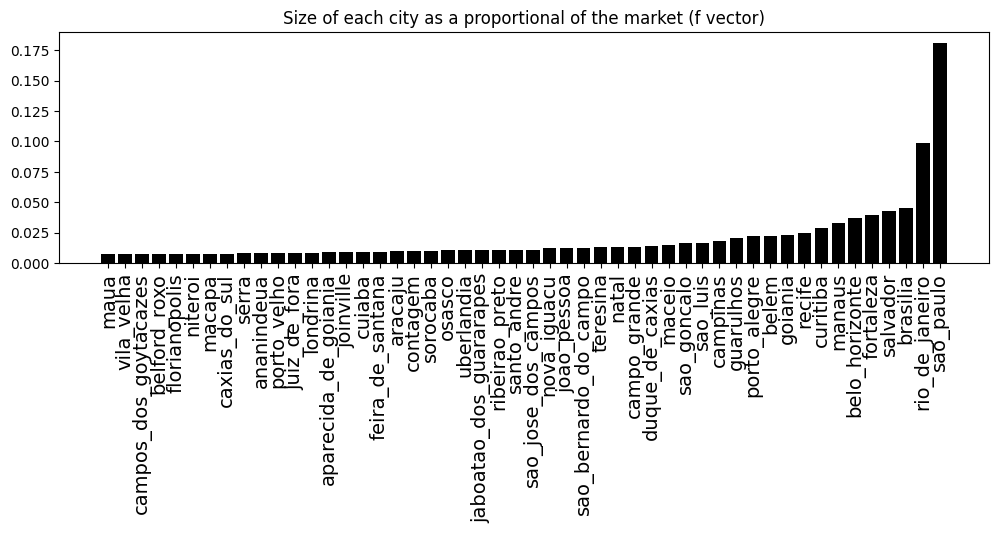

In [9]:
plt.figure(figsize=(12,3))
plt.bar(f.sort_values().index, f.sort_values().values)
plt.title("Size of each city as a proportional of the market (f vector)")
plt.xticks(rotation=90, fontsize=14);

### Trying a Random Set of Treated Units


In [10]:
y_avg = df_piv.dot(f)
geos = list(df_piv.columns)
n_tr = 5

In [11]:
np.random.seed(1)
rand_geos = np.random.choice(geos, n_tr, replace=False)
rand_geos

array(['manaus', 'recife', 'sao_bernardo_do_campo', 'salvador', 'aracaju'],
      dtype='<U23')

In [12]:
def get_sc(geos, df_sc, y_mean_pre):
    
    model = SyntheticControl(fit_intercept=True)
    model.fit(df_sc[geos], y_mean_pre)
    
    selected_geos = geos[np.abs(model.w_) > 1e-5]
    
    return {"geos": selected_geos, "loss": model.loss_ }


get_sc(rand_geos, df_piv, y_avg)

{'geos': array(['salvador', 'aracaju'], dtype='<U23'),
 'loss': 1598616.8087526597}

In [13]:
def get_sc_st_combination(treatment_geos, df_sc, y_mean_pre):
    
    treatment_result = get_sc(treatment_geos, df_sc, y_mean_pre)
    
    remaining_geos = df_sc.drop(
        columns=treatment_result["geos"]
    ).columns
    
    control_result = get_sc(remaining_geos, df_sc, y_mean_pre)

    return {"st_geos": treatment_result["geos"],
            "sc_geos": control_result["geos"],
            "loss": treatment_result["loss"] + control_result["loss"]}


resulting_geos = get_sc_st_combination(rand_geos, df_piv, y_avg)

In [14]:
resulting_geos.get("st_geos")

array(['salvador', 'aracaju'], dtype='<U23')

In [15]:
len(resulting_geos.get("st_geos")) + len(resulting_geos.get("sc_geos"))

50

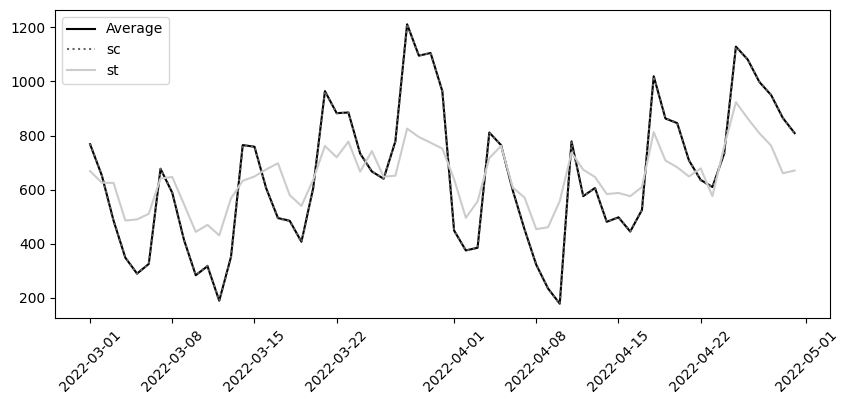

In [16]:
synthetic_tr = SyntheticControl(fit_intercept=True)
synthetic_co = SyntheticControl(fit_intercept=True)

synthetic_tr.fit(df_piv[resulting_geos.get("st_geos")], y_avg)
synthetic_co.fit(df_piv[resulting_geos.get("sc_geos")], y_avg)

plt.figure(figsize=(10,4))
plt.plot(y_avg, label="Average")
plt.plot(y_avg.index, synthetic_co.predict(df_piv[resulting_geos.get("sc_geos")]), label="sc", ls=":")
plt.plot(y_avg.index, synthetic_tr.predict(df_piv[resulting_geos.get("st_geos")]), label="st")


plt.xticks(rotation=45)
plt.legend()

### Random Search


In [17]:
from joblib import Parallel, delayed
from toolz import partial

np.random.seed(1)
geo_samples = [np.random.choice(geos, n_tr, replace=False) 
               for _ in range(1000)]

est_combination = partial(get_sc_st_combination,
                          df_sc=df_piv,
                          y_mean_pre=y_avg)

results = Parallel(n_jobs=4)(delayed(est_combination)(geos)
                             for geos in geo_samples)

/home/vscode/.local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-pack

In [18]:
resulting_geos = min(results, key=lambda x: x.get("loss"))
resulting_geos.get("st_geos")

array(['nova_iguacu', 'belem', 'joinville', 'sao_paulo'], dtype='<U23')

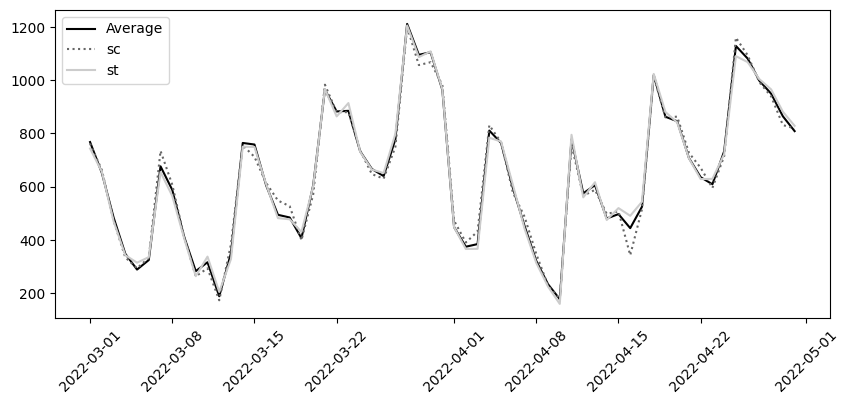

In [19]:
synthetic_tr = SyntheticControl(fit_intercept=True)
synthetic_co = SyntheticControl(fit_intercept=True)

synthetic_tr.fit(df_piv[resulting_geos.get("st_geos")], y_avg)
synthetic_co.fit(df_piv[resulting_geos.get("sc_geos")], y_avg)


plt.figure(figsize=(10,4))
plt.plot(y_avg, label="Average")
plt.plot(y_avg.index, synthetic_co.predict(df_piv[resulting_geos.get("sc_geos")]), label="sc", ls=":")
plt.plot(y_avg.index, synthetic_tr.predict(df_piv[resulting_geos.get("st_geos")]), label="st")


plt.xticks(rotation=45)
plt.legend()


## Switchback Experiment


In [20]:
df = pd.read_csv("./data/sb_exp_every.csv")
df.head()

,d,delivery_time,delivery_time_1,delivery_time_0,tau
0,1,2.84,2.84,5.84,-3.0
1,0,4.49,1.49,6.49,-5.0
2,0,7.27,2.27,8.27,-6.0
3,1,5.27,2.27,8.27,-6.0
4,1,5.59,4.59,10.59,-6.0


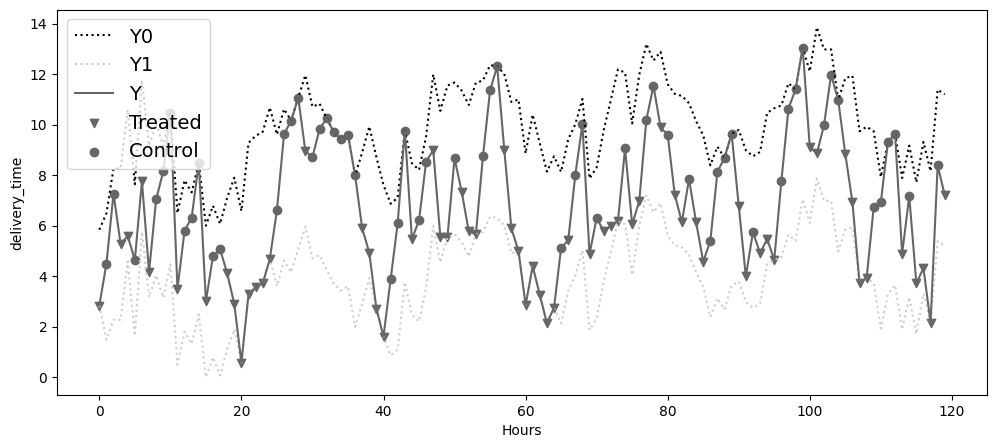

In [21]:
plt.figure(figsize=(12,5))
x = df.index
plt.plot(x, df["delivery_time_0"], ls=":", color="0.0", label="Y0")
plt.plot(x, df["delivery_time_1"], ls=":", color="0.8", label="Y1")
plt.plot(x, df["delivery_time"], color="0.4", label="Y")
plt.scatter(x[df["d"]==1], df["delivery_time"][df["d"]==1], label="Treated", marker="v", color="0.4")
plt.scatter(x[df["d"]==0], df["delivery_time"][df["d"]==0], label="Control", marker="o", color="0.4")
plt.ylabel("delivery_time")
plt.xlabel("Hours")
plt.legend(fontsize=14)


### Potential Outcomes of Sequences

### Estimating the Order of Carryover Effect


In [22]:
df_lags = df.assign(**{
    f"d_l{l}" : df["d"].shift(l) for l in range(7)
})

df_lags[[f"d_l{l}" for l in range(7)]].head()

,d_l0,d_l1,d_l2,...,d_l4,d_l5,d_l6
0,1,NaN,NaN,...,NaN,NaN,NaN
1,0,1.0,NaN,...,NaN,NaN,NaN
2,0,0.0,1.0,...,NaN,NaN,NaN
3,1,0.0,0.0,...,NaN,NaN,NaN
4,1,1.0,0.0,...,1.0,NaN,NaN


In [23]:
import statsmodels.formula.api as smf

model = smf.ols("delivery_time ~" + "+".join([f"d_l{l}"
                                              for l in range(7)]),
                data=df_lags).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3270,0.461,20.246,0.000,8.414,10.240
d_l0,-2.9645,0.335,-8.843,0.000,-3.629,-2.300
d_l1,-1.8861,0.339,-5.560,0.000,-2.559,-1.213
d_l2,-1.0013,0.340,-2.943,0.004,-1.676,-0.327
d_l3,0.2594,0.341,0.762,0.448,-0.416,0.935
d_l4,0.1431,0.340,0.421,0.675,-0.531,0.817
d_l5,0.1388,0.340,0.408,0.684,-0.536,0.813
d_l6,0.5588,0.336,1.662,0.099,-0.108,1.225


In [24]:
## remember to remove the intercept
tau_m_hat = model.params[1:].sum() 
se_tau_m_hat = np.sqrt((model.bse[1:]**2).sum()) 
print("tau_m:", tau_m_hat)
print("95% CI:", [tau_m_hat -1.96*se_tau_m_hat,
                  tau_m_hat +1.96*se_tau_m_hat])

tau_m: -4.751686115272039
95% CI: [-6.508718378154576, -2.9946538523895025]


In [25]:
## selecting lags 0, 1 and 2
tau_m_hat = model.params[1:4].sum() 
se_tau_m_hat = np.sqrt((model.bse[1:4]**2).sum()) 
print("tau_m:", tau_m_hat)
print("95% CI:", [tau_m_hat -1.96*se_tau_m_hat,
                  tau_m_hat +1.96*se_tau_m_hat])

tau_m: -5.8518568954423
95% CI: [-7.000105171362172, -4.703608619522427]


### Design Based Estimation


In [26]:
rad_points_3 = np.array([True, False, False]*(2))
rad_points_3

array([ True, False, False,  True, False, False])

In [27]:
rad_points_3.cumsum()

array([1, 1, 1, 2, 2, 2])

In [28]:
from numpy.lib.stride_tricks import sliding_window_view

m = 2
sliding_window_view(rad_points_3.cumsum(), window_shape=m+1)

array([[1, 1, 1],
       [1, 1, 2],
       [1, 2, 2],
       [2, 2, 2]])

In [29]:
np.diff(sliding_window_view(rad_points_3.cumsum(), 3), axis=1)

array([[0, 0],
       [0, 1],
       [1, 0],
       [0, 0]])

In [30]:
n_rand_windows = np.concatenate([
    [np.nan]*m,
    np.diff(sliding_window_view(rad_points_3.cumsum(), 3),
            axis=1).sum(axis=1)+1
])

n_rand_windows

array([nan, nan,  1.,  2.,  2.,  1.])

In [31]:
p=0.5
p**n_rand_windows

array([ nan,  nan, 0.5 , 0.25, 0.25, 0.5 ])

In [32]:
def compute_p(rand_points, m, p=0.5):
    n_windows_last_m = np.concatenate([
        [np.nan]*m,
        np.diff(sliding_window_view(rand_points.cumsum(), m+1),
                axis=1).sum(axis=1)+1
    ])
    return p**n_windows_last_m

compute_p(np.ones(6)==1, 2, 0.5)

array([  nan,   nan, 0.125, 0.125, 0.125, 0.125])

In [33]:
rand_points = np.array([True, False, False, True, False, True, False])
compute_p(rand_points, 2, 0.5)

array([ nan,  nan, 0.5 , 0.25, 0.25, 0.25, 0.25])

In [34]:
def last_m_d_equal(d_vec, d, m):
    return np.concatenate([
        [np.nan]*m,
        (sliding_window_view(d_vec, m+1)==d).all(axis=1)
    ])

print(last_m_d_equal([1, 1, 1, 0, 0, 0], 1, m=2))
print(last_m_d_equal([1, 1, 1, 0, 0, 0], 0, m=2))

[nan nan  1.  0.  0.  0.]
[nan nan  0.  0.  0.  1.]


In [35]:
def ipw_switchback(d, y, rand_points, m, p=0.5):
    
    p_last_m_equal_1 = compute_p(rand_points, m=m, p=p)
    p_last_m_equal_0 = compute_p(rand_points, m=m, p=1-p)
    
    last_m_is_1 = last_m_d_equal(d,1,m)
    last_m_is_0 = last_m_d_equal(d,0,m)
  
    y1_rec = y*last_m_is_1/p_last_m_equal_1
    y0_rec = y*last_m_is_0/p_last_m_equal_0
    
    return np.mean((y1_rec-y0_rec)[m:])

In [36]:
ipw_switchback(df["d"],
               df["delivery_time"],
               np.ones(len(df))==1,
               m=2, p=0.5)

-7.426440677966101

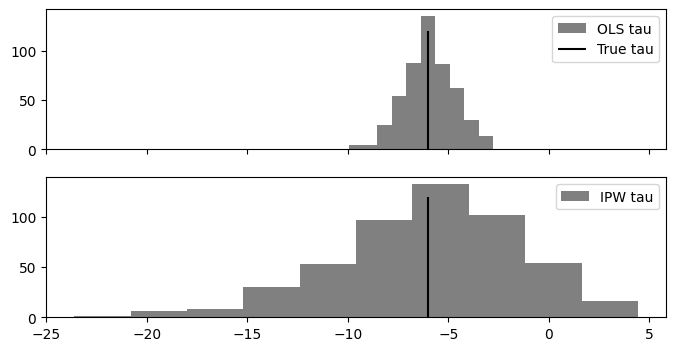

In [37]:
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess


def gen_d(rand_points, p):
    result = [np.random.binomial(1, p)]
    
    for t in rand_points[1:]:
        result.append(np.random.binomial(1, p)*t + (1-t)*result[-1])
    
    return np.array(result)


def y_given_d(d, effect_params, T, seed=None):
    np.random.seed(seed) if not seed is None else None
    x = np.arange(1, T+1)
    return (np.log(x+1)
            + 2*np.sin(x*2*np.pi/24)
            + np.convolve(~d.astype(bool), effect_params)[:-(len(effect_params)-1)]
            + ArmaProcess([3,2,1], 12).generate_sample(T)).round(2)



def gen_data_rand_every():
    effect_params = [3,2,1]
    T=120
    p=0.5
    m=2
    
    d = np.random.binomial(1, 0.5, T)
    y = y_given_d(d, [3,2,1], T)
    rand_points = np.ones(T)==1
    
    return pd.DataFrame(dict(d=d, y=y, rand_points=rand_points))


def tau_ols(df):
    df_lags = df.assign(**{
        f"d_l{l}" : df["d"].shift(l) for l in range(3)
    })
    model = smf.ols("y ~" + "+".join([f"d_l{l}" for l in range(3)]),data=df_lags).fit()
    return model.params[1:].sum()

def tau_ipw(df):
    return ipw_switchback(df["d"],
                          df["y"],
                          df["rand_points"],
                          m=2, p=0.5)
    

    
np.random.seed(123)
exps_dfs = [gen_data_rand_every() for _ in range(500)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
ols_taus = list(map(tau_ols, exps_dfs))
ax1.hist(ols_taus, label="OLS tau", color="0.5")
ax1.vlines(-6, 0, 120, color="0", label="True tau")
ax1.legend()

ipw_taus = list(map(tau_ipw, exps_dfs))
ax2.hist(ipw_taus, label="IPW tau", color="0.5");
ax2.vlines(-6, 0, 120,  color="0")
ax2.legend()


### Optimal Switchback Design


In [38]:
m = 2
T = 12
n = T/m
np.isin(
    np.arange(1, T+1),
    [1] + [i*m+1 for i in range(2, int(n)-1)]
)*1

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [39]:
m = 3
T = 15
n = T/m
np.isin(
    np.arange(1, T+1),
    [1] + [i*m+1 for i in range(2, int(n)-1)]
)*1

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [40]:
def gen_d(rand_points, p):
    result = [np.random.binomial(1, p)]
    
    for t in rand_points[1:]:
        result.append(np.random.binomial(1, p)*t + (1-t)*result[-1])
    
    return np.array(result)

T = 120
m = 2

def gen_exp(rand_points, T):
    effect_params = [3,2,1]
    p=0.5
    
    d = gen_d(rand_points, p=p)
    y = y_given_d(d, [3,2,1], T)

    return pd.DataFrame(dict(d=d, y=y, rand_points=rand_points))


every_1 = np.array([True]*T)
every_3 = np.array([True, False, False]*(T//3))
n = T//m
opt = np.isin(
    np.arange(1, T+1),
    [1] + [i*m+1 for i in range(2, int(n)-1)]
)

np.random.seed(123)
exps_every_1 = [gen_exp(every_1, T) for _ in range(1000)]
exps_every_3 = [gen_exp(every_3, T) for _ in range(1000)]
exps_opt = [gen_exp(opt, T) for _ in range(1000)]

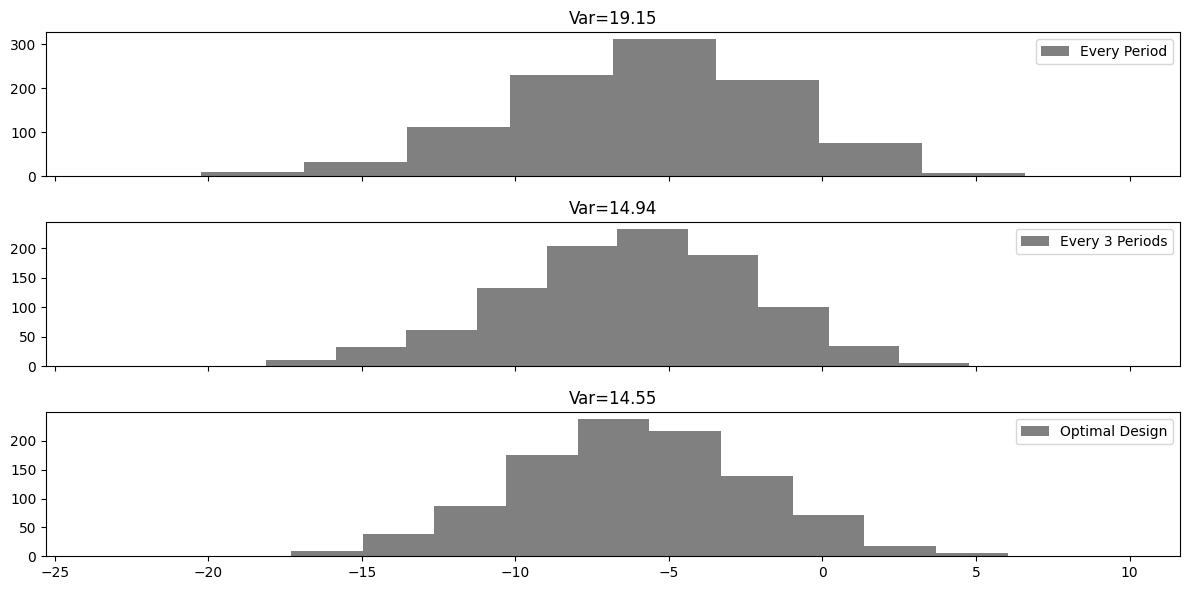

In [41]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 6))
ax1, ax2, ax3 = axs.ravel()

taus_every_1_ipw = list(map(tau_ipw, exps_every_1))
ax1.hist(taus_every_1_ipw, label="Every Period", color="0.5")
ax1.set_title(f"Var={np.round(np.var(taus_every_1_ipw), 2)}")
ax1.legend()


taus_every_3_ipw = list(map(tau_ipw, exps_every_3))
ax2.hist(taus_every_3_ipw, label="Every 3 Periods", color="0.5");
ax2.set_title(f"Var={np.round(np.var(taus_every_3_ipw), 2)}")
ax2.legend()

taus_opt_ipw = list(map(tau_ipw, exps_opt))
ax3.hist(taus_opt_ipw, label="Optimal Design", color="0.5");
ax3.set_title(f"Var={np.round(np.var(taus_opt_ipw), 2)}")
ax3.legend()

plt.tight_layout()

### Robust Variance


In [42]:
df_opt = pd.read_csv("./data/sb_exp_opt.csv")
df_opt.head(6)

,rand_points,d,delivery_time
0,True,0,5.84
1,False,0,6.49
2,False,0,8.27
3,False,0,8.27
4,True,0,10.59
5,False,0,7.64


In [43]:
tau_hat = ipw_switchback(df_opt["d"],
                         df_opt["delivery_time"],
                         df_opt["rand_points"],
                         m=2, p=0.5)

tau_hat

-9.867627118644068

In [44]:
np.vstack(np.hsplit(np.array([1,1,1,2,2,3]), 3))

array([[1, 1],
       [1, 2],
       [2, 3]])

In [45]:
np.diff(np.vstack(np.hsplit(np.array([1,1,0,0,0,0]), 3))[:, 0]) == 0

array([False,  True])

In [46]:
def var_opt_design(d_opt, y_opt, T, m):
    
    assert ((T//m == T/m)
            & (T//m >= 4)), "T must be divisible by m and T/m >= 4"
    
    # discard 1st block
    y_m_blocks = np.vstack(np.hsplit(y_opt, int(T/m))).sum(axis=1)[1:]
    
    # take 1st column
    d_m_blocks = np.vstack(np.split(d_opt, int(T/m))[1:])[:, 0] 
    
    return (
        8*y_m_blocks[0]**2 
        + (32*y_m_blocks[1:-1]**2*(np.diff(d_m_blocks)==0)[:-1]).sum()
        + 8*y_m_blocks[-1]**2 
    ) / (T-m)**2

In [47]:
se_hat = np.sqrt(var_opt_design(df_opt["d"],
                                df_opt["delivery_time"],
                                T=120, m=2))

[tau_hat - 1.96*se_hat, tau_hat + 1.96*se_hat]

[-18.396022587930865, -1.3392316493572718]

## Key Ideas
